## Metropolis for force field fitting

In [1]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import scipy.stats as stt
from scipy.optimize import curve_fit
from scipy.optimize import minimize
import numpy as np
import time
import os

In [2]:
%run beta_lossfunction.ipynb

### load data

In [3]:
name_sys=["ADE","CYT"]
names=np.array([["weightsADE","sugar_couplADE","exp_sugarADE","trajADE"],["weightsCYT","sugar_couplCYT","exp_sugarCYT","trajCYT"]])

nsystems=np.shape(name_sys)[0]

userdoc = os.path.join(os.path.expanduser("~"),'1_project/initial_data')
for i_sys in range(nsystems):
        exec(names[i_sys,0]+"=np.loadtxt(os.path.join(userdoc,'"+names[i_sys,0]+"'),delimiter=',')")
        exec(names[i_sys,1]+"=np.loadtxt(os.path.join(userdoc,'"+names[i_sys,1]+"'),delimiter=',')")
        exec(names[i_sys,2]+"=np.loadtxt(os.path.join(userdoc,'"+names[i_sys,2]+"'),delimiter=',')")
        exec(names[i_sys,3]+"=np.loadtxt(os.path.join(userdoc,'"+names[i_sys,3]+"'),delimiter=',')")

if you wish, take a subset of force field correction terms (angle $\delta$ doesn't work well)

In [4]:
trajADE=trajADE[:,[0,1,6,7,12,13]]
trajCYT=trajCYT[:,[0,1,6,7,12,13]]

indicate the corresponding terms

In [5]:
#nff=24
#parmap=np.array([[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0],[1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,1,1,1,1,1,1]])

nff=8
parmap=np.array([[1,1,1,1,1,1,0,0],[1,1,1,1,0,0,1,1]])


take optimal $\beta$ (from cross validation)

In [6]:
beta=0.2

gradient=True

### beta_lossf minimization over the whole dataset for the estimated optimal $\beta$ ($\beta=0.2$)

example

In [7]:
par0=np.random.uniform(0,1,nff)
print(par0)
beta_lossf(par0)


[0.66976838 0.72078052 0.31773306 0.25910904 0.93484399 0.28608042
 0.07392309 0.31949222]


(13.100662828211831,
 array([-3.70491513, -2.01788697,  9.91543998,  3.44553759, -3.91577285,
        -3.35024193, -1.9537669 ,  1.80194124]),
 [0.9146086798156937, 2.794930068058004],
 [-0.3765982377106434, -0.20978781555879988])

minimization of beta_lossf over the whole data set, to get $\color{red}{minlossf, minphis, cov}$

In [8]:
par0=np.random.uniform(0,1,nff)
print('starting point: ',par0)

# minimization
start=time.time()
mini=minimize(beta_lossf, par0, method="BFGS",jac=True)#,options={'gtol': 1e-20, 'disp': True})#tol=10**(-30))#,bounds=bounds)
print("Minimization time:",time.time()-start)
print(mini)

minlossf=mini.fun
cov=mini.hess_inv
minphis=mini.x


starting point:  [0.99225647 0.36803157 0.81547416 0.40120527 0.84301461 0.8768453
 0.36666704 0.10595242]
Minimization time: 0.44762277603149414
      fun: 2.4470344020589994
 hess_inv: array([[ 1.40872180e-01,  2.61268898e-02,  1.62790500e-01,
        -5.18210169e-01, -1.21367475e-01,  1.51209759e-02,
        -4.16279197e-01,  5.35639924e-02],
       [ 2.61268898e-02,  4.76766989e-01,  1.60809660e+00,
        -4.20706232e+00, -5.60593326e-02, -1.00882779e-01,
        -6.48823556e-01, -3.25422075e-01],
       [ 1.62790500e-01,  1.60809660e+00,  1.83942677e+01,
        -4.12169316e+01,  2.36699075e+00, -6.59096789e-01,
         3.08907917e+00, -2.47077299e+00],
       [-5.18210169e-01, -4.20706232e+00, -4.12169316e+01,
         9.41660229e+01, -4.47898487e+00,  1.68359980e+00,
        -3.87359672e+00,  6.74267183e+00],
       [-1.21367475e-01, -5.60593326e-02,  2.36699075e+00,
        -4.47898487e+00,  1.17733525e+00, -3.85161911e-01,
         1.79956036e+00,  2.35996044e-01],
       [

### point of minimum, eigenvalues and eigenvectors
- compute the eigenvalues and eigenvectors of the covariance matrix (inverse hessian in the point of minimum, from the whole data set)
- look at the numerical round-off error in the covariance matrix (which must be symmetric), needed for using it in the multivariate gaussian, correct the error by symmetrizing it
- compare the value of the point of minimum with the one coming from bootstrap computation (use as errors the sqrt of the diagonal elements; for bootstrap data you can use this or the std from bootstrap)
- compare the covariance matrix with the average covariance matrix from the bootstrap computation (its eigenvectors and variances, i.e. diagonal elements)


In [9]:
eigvaltot,eigvectot=np.linalg.eigh(cov)
whole_std=np.sqrt(np.diag(cov))
print(eigvaltot)
diff=cov-cov.T

a=np.where(diff==np.max(diff))
print('max. numerical error in cells: ',a)
print(cov[a[0],a[1]])
print(cov[a[1],a[0]])

goodcov=(cov+cov.T)/2
phis=np.random.multivariate_normal(minphis,goodcov,size=1)
print(phis)

[2.93484843e-02 8.59555126e-02 2.02071476e-01 5.10115808e-01
 1.08395751e+00 7.79061205e+00 1.55783304e+01 1.13447263e+02]
max. numerical error in cells:  (array([7]), array([3]))
[6.74267183]
[6.74267183]
[[ 0.61053231 -0.07317413 -4.81881367 13.50465215  1.63504878  0.28436739
   8.53069189 -5.79342446]]


(array([7]), array([6]))
-2403101.5220467034
-2403102.3552063955


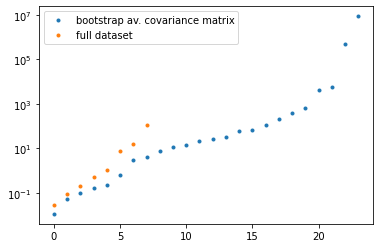

In [10]:
bootstrdoc=os.path.join(os.path.expanduser('~'),'1_project/data_FFF/bootstrap2')
av_covs=np.loadtxt(os.path.join(bootstrdoc,"av_covs"),delimiter=',')

print(np.where((av_covs-av_covs.T)==np.max(av_covs-av_covs.T)))
diff=av_covs-av_covs.T
print(av_covs[7,6])
print(av_covs[6,7])
eigval,eigvec=np.linalg.eigh(av_covs)

plt.plot(eigval,'.',label='bootstrap av. covariance matrix')
plt.plot(eigvaltot,'.',label='full dataset')
plt.yscale('log')
plt.legend()

#phis=np.random.multivariate_normal(minphis,av_covs,size=1)
#print(phis)

ValueError: operands could not be broadcast together with shapes (8,) (24,) 

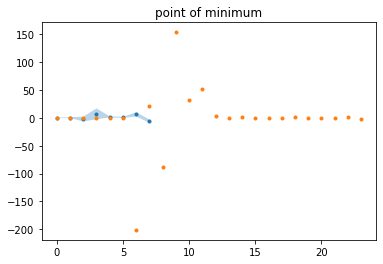

In [11]:
phis=np.loadtxt(os.path.join(bootstrdoc,"minpars"),delimiter=',')
av_phis=np.mean(phis,axis=0)
std_phis=np.std(phis,axis=0)
nff=len(minphis)

plt.title('point of minimum')
plt.plot(minphis,'.',label='full dataset')
plt.fill_between(np.arange(nff),minphis-np.sqrt(np.diag(cov)),minphis+np.sqrt(np.diag(cov)),alpha=0.3)
plt.plot(av_phis,'.',label='bootstrap')
plt.fill_between(np.arange(nff),av_phis-std_phis,av_phis+std_phis,alpha=0.3)
#plt.ylim([-5,5])#[3/2*np.min(minphis),3/2*np.max(minphis)])
plt.grid()
plt.legend()


### Metropolis:
- trial function: the proposal move, a uniform distribution for the parameters shift in $(-\delta,+\delta)^{nff}$; better doing a suitable choice for $\delta$, by taking it as a fraction frac of the standard deviations (sqrt diagonal elements of the inverse hessian in the point of minimum; hypothesis it work well even far from the global minimum)
- sampling function: Metropolis algorithm
    - input: nsteps, delta (how to propose the move), z0 (how to do initialization: the point of min. + a random n. from the multivariate gaussian times z0)

In [12]:
def trial(phi,delta):
    return phi+(np.random.rand(len(phi))*2-1)*delta
    

In [13]:
def quadratic(phi,phi0,inv_cov):
    return 1/2*np.matmul(np.matmul(phi-phi0,inv_cov),phi-phi0)

In [14]:
def sampling(delta=0.1,nsteps=100,z0=1,if_quad=False):

    traj=[]
    iter=[]
    avalpha=0
    lossfs=[]

    phi=minphis+np.random.multivariate_normal(np.zeros(len(minphis)),goodcov,size=1)[0,:]*z0

    traj.append(phi)
    iter.append(0)

    if if_quad: # quadratic approximation of the loss function around the minimum
        inv_cov=np.linalg.inv(goodcov)
        lossf=quadratic(phi,minphis,inv_cov)
    else:
        lossf=beta_lossf(phi)[0]

    lossfs.append(lossf)

    for istep in range(nsteps):
        #####################
        # if same delta:
        #delta=0.1
        # else:
        # better, different deltas for different coordinates, estimated with the covariance at MAP
        delta=0.1*np.sqrt(np.diag(goodcov))
        #   if all coordinates:
        phitry=trial(phi,delta=delta)

        #   else (if only one coordinate):
        #phitry=phi
        #phitry[i_coord]=trial([phi[i_coord]],delta=delta[i_coord])
        ######################
        
        if if_quad:
            lossf_try=+quadratic(phitry,minphis,inv_cov)
        else:
            lossf_try=+beta_lossf(phitry)[0]

        #print(lossf_try)
        alpha=np.exp(lossf-lossf_try)
        if alpha>1: alpha=1
        if alpha>np.random.rand():
            avalpha+=1
            phi=+phitry
            lossf=+lossf_try

        traj.append(phi)
        iter.append(istep+1)
        lossfs.append(lossf)

    avalpha=avalpha/nsteps
    

    return np.array(iter),np.array(traj),avalpha,lossfs

### quadratic approximation or not?

In [15]:
iter,traj,avalpha,lossf=sampling(nsteps=10000,z0=0.2,if_quad=False)

### analyse the results of Metropolis sampling

average acceptance:

In [16]:
print(avalpha)

0.5982


first and last sampling you want to consider, among all the Metropolis ones

In [17]:
nsampl1=0
nsampl2=len(iter)
#nsampl2=5000

loss function:

min. of the loss f:  2.4470344020589994
sampling between:  0 10001


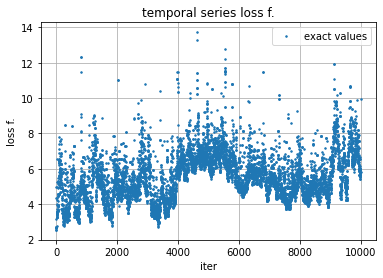

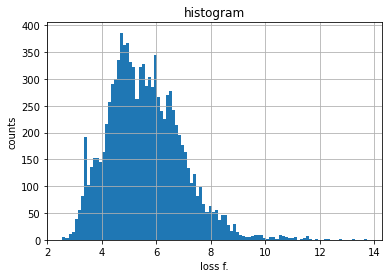

In [18]:
print('min. of the loss f: ',minlossf)

print('sampling between: ',nsampl1,nsampl2)

if_alsoquad=False

if if_alsoquad:
    inv_cov=np.linalg.inv(goodcov)
    diff2=1/2*np.einsum('ij,jk,ik->i',traj-minphis,inv_cov,traj-minphis)+minlossf

plt.figure()
plt.plot(iter[nsampl1:nsampl2],lossf[nsampl1:nsampl2],'.',markersize=3,label='exact values')
if if_alsoquad:
    plt.plot(iter[nsampl1:nsampl2],diff2[nsampl1:nsampl2],'.',markersize=2,label='quad.approx.')
plt.title('temporal series loss f.')
plt.xlabel('iter')
plt.ylabel('loss f.')
plt.grid()
plt.legend()

plt.figure()
plt.title('histogram')
hist,bins,_=plt.hist(lossf[nsampl1:nsampl2],bins=100)
plt.xlabel('loss f.')
plt.ylabel('counts')
plt.grid()

if if_alsoquad:
    plt.figure()
    hist2,bins2,_=plt.hist(diff2[nsampl1:nsampl2],bins=100,label='data')
    plt.title('quadratic approx.')
    plt.xlabel('loss f. (approx)')
    plt.ylabel('counts')
    plt.grid()

In [18]:
# Define the Gaussian function
def Gauss(x, A, B, mu):
    y = A*np.exp(-1/(2*B)*(x-mu)**2)
    return y

force field parameters:

choose the parameter

In [21]:
i=5

NameError: name 'Gauss' is not defined

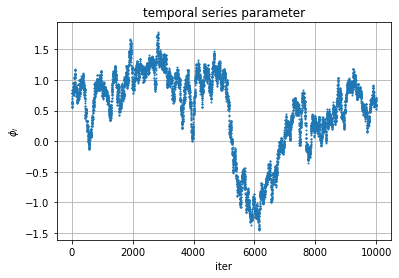

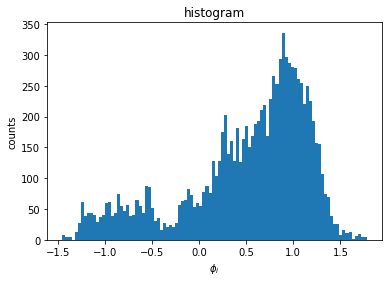

In [20]:
plt.figure()
plt.plot(iter[nsampl1:nsampl2],traj[nsampl1:nsampl2,i],'.',markersize=2)
plt.title('temporal series parameter')
plt.ylabel(r'$\phi_i$')
plt.xlabel('iter')
#plt.xlim([0,2000])
plt.grid()

plt.figure()
plt.title('histogram')
plt.xlabel('$\phi_i$')
plt.ylabel('counts')
hist,bins,_=plt.hist(traj[nsampl1:nsampl2,i],bins=100,label='data')

parameters,covariance=curve_fit(Gauss, bins[:-1],hist)
  
fit_A = parameters[0]
fit_B = parameters[1]
fit_C = parameters[2]
  
fit_y = Gauss(bins[:-1], fit_A, fit_B, fit_C)
#plt.plot(bins[:-1], hist, '.', label='data')
plt.plot(bins[:-1], fit_y, '-', label='fit')
plt.legend()
plt.grid()
plt.show()

print('expected values (from minimization):')
print('mode (point of min.): ',minphis[i])
#print('mode (from bootstrap): ',av_phis[i])

print('standard deviation: ',np.sqrt(np.diag(cov))[i])

print('values from gaussian fit:')
print('average: ',parameters[2])
print('standard deviation: ',np.sqrt(parameters[1]))



loss function in quadratic approximation, computed from parameters' values with mean and covariance values from minimization; compare it with the actual values of the loss function

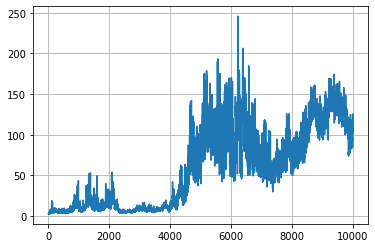

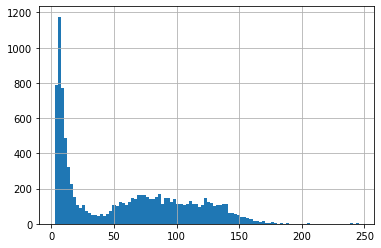

In [147]:
inv_cov=np.linalg.inv(goodcov)
diff2=1/2*np.einsum('ij,jk,ik->i',traj-minphis,inv_cov,traj-minphis)+minlossf

plt.plot(diff2)
plt.grid()

plt.figure()
hist,bins,_=plt.hist(diff2,bins=100,label='data')
plt.grid()

## Data from long simulations (run5)

In [22]:
userdoc = os.path.join(os.path.expanduser("~"),'1_project/data_FFF/Metropolis1')
lossf=np.loadtxt(os.path.join(userdoc,"lossf"),delimiter=',')
avalpha=np.loadtxt(os.path.join(userdoc,"avalpha"),delimiter=',')
traj=np.loadtxt(os.path.join(userdoc,"traj"),delimiter=',')

iter=np.arange(len(traj))

min. of the loss f:  2.4470344020589994


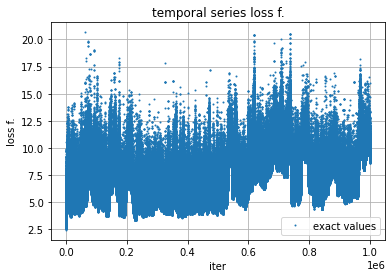

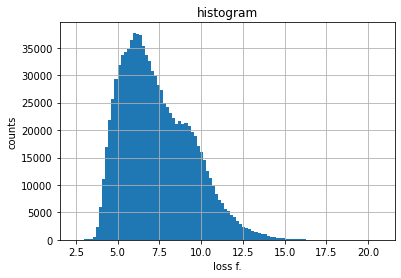

In [23]:
print('min. of the loss f: ',minlossf)

if_alsoquad=False

if if_alsoquad:
    inv_cov=np.linalg.inv(goodcov)
    diff2=1/2*np.einsum('ij,jk,ik->i',traj-minphis,inv_cov,traj-minphis)+minlossf

plt.figure()
plt.plot(iter,lossf,'.',markersize=2,label='exact values')
if if_alsoquad:
    plt.plot(iter,diff2,'.',markersize=2,label='quad.approx.')
plt.title('temporal series loss f.')
plt.xlabel('iter')
plt.ylabel('loss f.')
plt.grid()
plt.legend()

plt.figure()
plt.title('histogram')
hist,bins,_=plt.hist(lossf,bins=100)
plt.xlabel('loss f.')
plt.ylabel('counts')
plt.grid()

if if_alsoquad:
    plt.figure()
    hist2,bins2,_=plt.hist(diff2,bins=100,label='data')
    plt.title('quadratic approx.')
    plt.xlabel('loss f. (approx)')
    plt.ylabel('counts')
    plt.grid()

In [28]:
i=7#i_coord
#upto=10000
upto=len(iter)

expected values (from minimization):
mode (point of min.):  -5.8037477607461705
standard deviation:  2.9326161471133494


NameError: name 'Gauss' is not defined

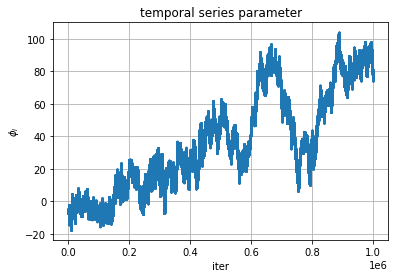

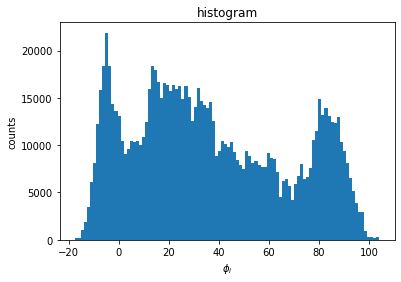

In [29]:
print('expected values (from minimization):')
print('mode (point of min.): ',minphis[i])
#print('mode (from bootstrap): ',av_phis[i])
print('standard deviation: ',np.sqrt(np.diag(cov))[i])

plt.figure()
plt.plot(iter[:upto],traj[:upto,i],'.',markersize=2)
plt.title('temporal series parameter')
plt.ylabel(r'$\phi_i$')
plt.xlabel('iter')
plt.grid()

plt.figure()
plt.title('histogram')
plt.xlabel('$\phi_i$')
plt.ylabel('counts')
hist,bins,_=plt.hist(traj[:upto,i],bins=100,label='data')

parameters,covariance=curve_fit(Gauss, bins[:-1],hist)
  
fit_A = parameters[0]
fit_B = parameters[1]
fit_C = parameters[2]
  
fit_y = Gauss(bins[:-1], fit_A, fit_B, fit_C)
#plt.plot(bins[:-1], hist, '.', label='data')
plt.plot(bins[:-1], fit_y, '-', label='fit')
plt.legend()
plt.grid()
plt.show()


print('values from gaussian fit:')
print('average: ',parameters[2])
print('standard deviation: ',np.sqrt(parameters[1]))

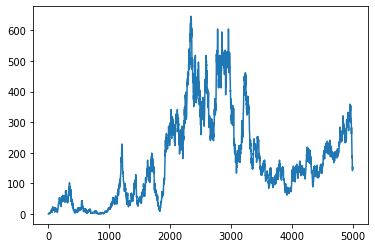

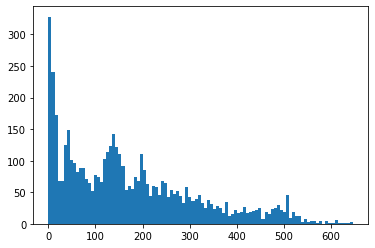

In [176]:
diff2=np.linalg.norm(traj-minphis,axis=1)**2
upto=5000
plt.plot(diff2[:upto])

plt.figure()
hist,bins,_=plt.hist(diff2[:upto],bins=100,label='data')